In [59]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import random
from PIL import Image

In [60]:
RETRAIN = False
PATH = 'cnn_model_q2'

In [61]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [62]:
def set_seeds(SEED):
	torch.manual_seed(SEED)
	np.random.seed(SEED * 2)
	random.seed(SEED * 3)

set_seeds(123)

In [63]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [64]:
class Net(nn.Module):
    def __init__(self, reconstruction_weight=1):
        super().__init__()
        self.rec_weight = reconstruction_weight
        
        self.L_ce = nn.CrossEntropyLoss()
        self.L_rec = nn.MSELoss()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.deconv1 = nn.ConvTranspose2d(6, 3, 5)
        
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.deconv2 = nn.ConvTranspose2d(16, 6, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y_tilde_temp, indices1 = self.pool(F.relu(self.conv1(x)))
        y_tilde_temp, indices2 = self.pool(F.relu(self.conv2(y_tilde_temp)))
        
        x_tilde_temp = self.deconv2(F.relu(self.unpool(y_tilde_temp, indices2)))
        x_tilde = self.deconv1(F.relu(self.unpool(x_tilde_temp, indices1)))
        
        y_tilde_temp = torch.flatten(y_tilde_temp, 1) # flatten all dimensions except batch
        y_tilde_temp = F.relu(self.fc1(y_tilde_temp))
        y_tilde_temp = F.relu(self.fc2(y_tilde_temp))
        y_tilde = self.fc3(y_tilde_temp)
        
        return y_tilde, x_tilde
    
    def total_loss(self,x ,x_tilde, y, y_tilde):
        cross_entropy = self.L_ce(y_tilde, y)
        reconstruction_element = self.L_rec(x, x_tilde)
        
        return cross_entropy + self.rec_weight*reconstruction_element

In [65]:
# Load the saved model
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (L_ce): CrossEntropyLoss()
  (L_rec): MSELoss()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (deconv1): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [66]:
# function to show dataset images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [67]:
# function to show reconstructed images
def imshow_reconstructed(tensor):
    # print(f"Before de-normalization: max={torch.max(tensor)}, min={torch.min(tensor)}")
    tensor -= tensor.amin(dim=(1,2,3), keepdim=True)
    tensor /= tensor.amax(dim=(1,2,3), keepdim=True)
    # print(f"After de-normalization: max={torch.max(tensor)}, min={torch.min(tensor)}")
        
    npimg = torchvision.utils.make_grid(tensor).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [68]:
# Select images from the train set and test set
images, labels = next(iter(trainloader))
train_image, train_label = images[0], labels[0]

images, labels = next(iter(testloader))
test_image, test_label = images[0], labels[0]

# imshow(train_image)
# imshow(test_image)

In [69]:
# Convert tensors to numpy arrays
# train_image_np = train_image.numpy()
# test_image_np = test_image.numpy()

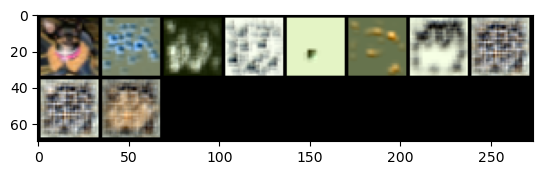

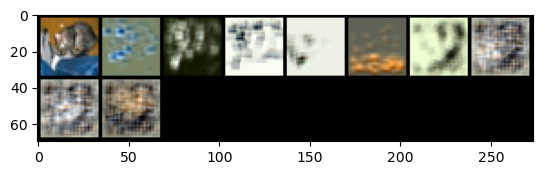

In [70]:
for image in [train_image, test_image]:
	# print(classes[test_label])
	# Generate reconstructions for the first convolutional layer
	conv1_reconstructions = []
	z1_image, indices1 = net.pool(F.relu(net.conv1(image)))
	num_channels = len(z1_image)

	for channel in range(num_channels):
		modified_features = z1_image.clone()
		
		modified_features[:channel] = 0
		modified_features[channel+1:] = 0
		
		reconstructed_image = net.deconv1(F.relu(net.unpool(modified_features, indices1)))
		
		conv1_reconstructions.append(reconstructed_image)

	# imshow(train_image)
	# imshow_reconstructed(torch.stack([train_image] + conv1_reconstructions))

	# Generate reconstructions for the second convolutional layer
	conv2_reconstructions = []
	z2_image, indices2 = net.pool(F.relu(net.conv2(z1_image)))
	num_channels = len(z2_image)

	for channel in np.linspace(0,num_channels,3, dtype=int, endpoint=False):
		modified_features = z2_image.clone()
		
		modified_features[:channel] = 0
		modified_features[channel+1:] = 0
		
		reconstructed_image = net.deconv2(F.relu(net.unpool(modified_features, indices2)))
		reconstructed_image = net.deconv1(F.relu(net.unpool(reconstructed_image, indices1)))
		
		conv2_reconstructions.append(reconstructed_image)

	# imshow(train_image)
	imshow_reconstructed(torch.stack([image] + conv1_reconstructions + conv2_reconstructions))